In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
from scipy.stats import ttest_ind
import pymc3 as pm
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('ticks')
sns.set_context('paper')

import glambox as gb

# Example 2: Hierarchical parameter estimation in cases with limited data

In some research settings, the total amount of data one can collect per individual is limited, conflicting with the large amounts of data required to obtain reliable and precise individual parameter estimates from diffusion models (see for example, Lerche at al. (2017) and Voss et al. (2013)). Hierarchical modeling can offer a solution to this problem. Here, each individual's parameter estimates are assumed to be drawn from a group level distribution. Thereby, during parameter estimation, individual parameter estimates are informed by the data of the entire group. This can greatly improve parameter estimation, especially in the face of limited amounts of data (see for example Ratcliff & Childers (2015) and Wiecki et al. (2013)). In this example, we will simulate a clinical application setting, in which different patient groups are to be compared on the strengths of their gaze biases, during a simple value-based choice task that includes eye tracking. It is reasonable to assume that the amount of data that can be collected in such a setting is limited on at least two accounts:

- The number of patients available for the experiment might be low
- The number of trials that can be performed by each participant might be low, for clinical reasons (e.g., patients feel exhausted more quickly, time to perform tests is limited, etc.)

Therefore, we simulate a dataset with a low number of individuals within each group (between 5 and 15 per group), and a low number of trials per participant (50 trials). We then estimate model parameters in a hierarchical fashion, and compare the group level gaze bias parameter estimates between groups.

## 1. Simulating Data

We simulate data of three patient groups ($N_1$ = 5, $N_2$ = 10, $N_3$ = 15), with 50 trials per individual, in a simple three item value-based choice task, where participants are instructed to simply choose the item they like the best. These numbers are roughly based on a recent clinical study on the role of the prefrontal cortex in fixation-dependent value representations (Vaidya & Fellows (2015)). Here, the authors found no systematic differences between frontal lobe patients and controls on integration speed or the decision threshold, controlling speed-accuracy trade-offs. Therefore, in our example we only let the gaze bias parameter $\gamma$ differ systematically between the groups, with means of $\gamma_{1}$ = 0.7 (weak gaze bias), $\gamma_{2}$ = 0.1 (moderate gaze bias) and $\gamma_{3}$ = −0.5 (strong gaze bias), respectively. We do not assume any other systematic differences between the groups and sample all other model parameters from the estimates obtained from fitting the model to the data of Krajbich & Rangel (2011).

In [2]:
## Load Krajbich & Rangel (2011) dataset estimates from Thomas, Molter et al. (2019)
estimates = pd.read_csv('resources/individual_estimates_sec_nhb2019.csv')
kr2011 = estimates.loc[estimates['dataset'] == 'krajbich2011']
kr2011.head()

,subject,dataset,v,gamma,s,tau
39,39,krajbich2011,1.207348,0.389116,0.227103,0.354587
40,40,krajbich2011,0.633304,0.353474,0.279450,0.622022
41,41,krajbich2011,0.737201,0.814595,0.282122,0.787967
42,42,krajbich2011,0.800456,-0.154669,0.328268,1.505673
43,43,krajbich2011,0.627823,0.658645,0.219142,0.549583


In [3]:
np.random.seed(1751)

groups = ['group1', 'group2', 'group3']

# Sample sizes
N = dict(group1=5,
         group2=10,
         group3=15)

# Mean gaze bias parameters for each group
gamma_mu = dict(group1=0.7,     # weak bias
                group2=0.1,     # medium-strong bias
                group3=-0.5)    # very strong bias with leak

# Sample parameter sets from KR2011 estimates
group_idx = {group: np.random.choice(kr2011.index, size=N[group], replace=False)
             for group in groups}
v = {group: kr2011.loc[group_idx[group], 'v'].values
     for group in groups}
s = {group: kr2011.loc[group_idx[group], 's'].values
     for group in groups}
tau = {group: kr2011.loc[group_idx[group], 'tau'].values
       for group in groups}

# Draw normally distributed gaze bias parameters (truncated to be ≤ 1)
gamma = dict(group1=np.clip(np.random.normal(loc=gamma_mu['group1'], scale=0.3, size=N['group1']), a_min=None, a_max=1),
             group2=np.clip(np.random.normal(loc=gamma_mu['group2'], scale=0.2, size=N['group2']), a_min=None, a_max=1),
             group3=np.clip(np.random.normal(loc=gamma_mu['group3'], scale=0.3, size=N['group3']), a_min=None, a_max=1))

# Set the number of trials and items in the task
n_trials = 50
n_items  = 3

# Simulate the data using GLAM
glam = gb.GLAM()
for g, group in enumerate(groups):
    glam.simulate_group(kind='individual',
                        n_individuals=N[group],
                        n_trials=n_trials,
                        n_items=n_items,
                        parameters=dict(v=v[group],
                                        gamma=gamma[group],
                                        s=s[group],
                                        tau=tau[group],
                                        t0=np.zeros(N[group])),
                        label=group,
                        seed=g)

data = glam.data.copy()
data.rename({'condition': 'group'}, axis=1, inplace=True)
data.to_csv('examples/example_2/data/data.csv', index=False)
data.head(3)

,subject,trial,repeat,choice,rt,item_value_0,gaze_0,item_value_1,gaze_1,item_value_2,gaze_2,group
0,0.0,0.0,0.0,0.0,1.266691,5,0.459175,0,0.379466,3,0.161359,group1
1,0.0,1.0,0.0,2.0,1.189464,3,0.389115,7,0.189588,9,0.421297,group1
2,0.0,2.0,0.0,1.0,1.709817,3,0.269665,5,0.409055,2,0.321280,group1


The resulting distribution of data generating parameters looks as follows:

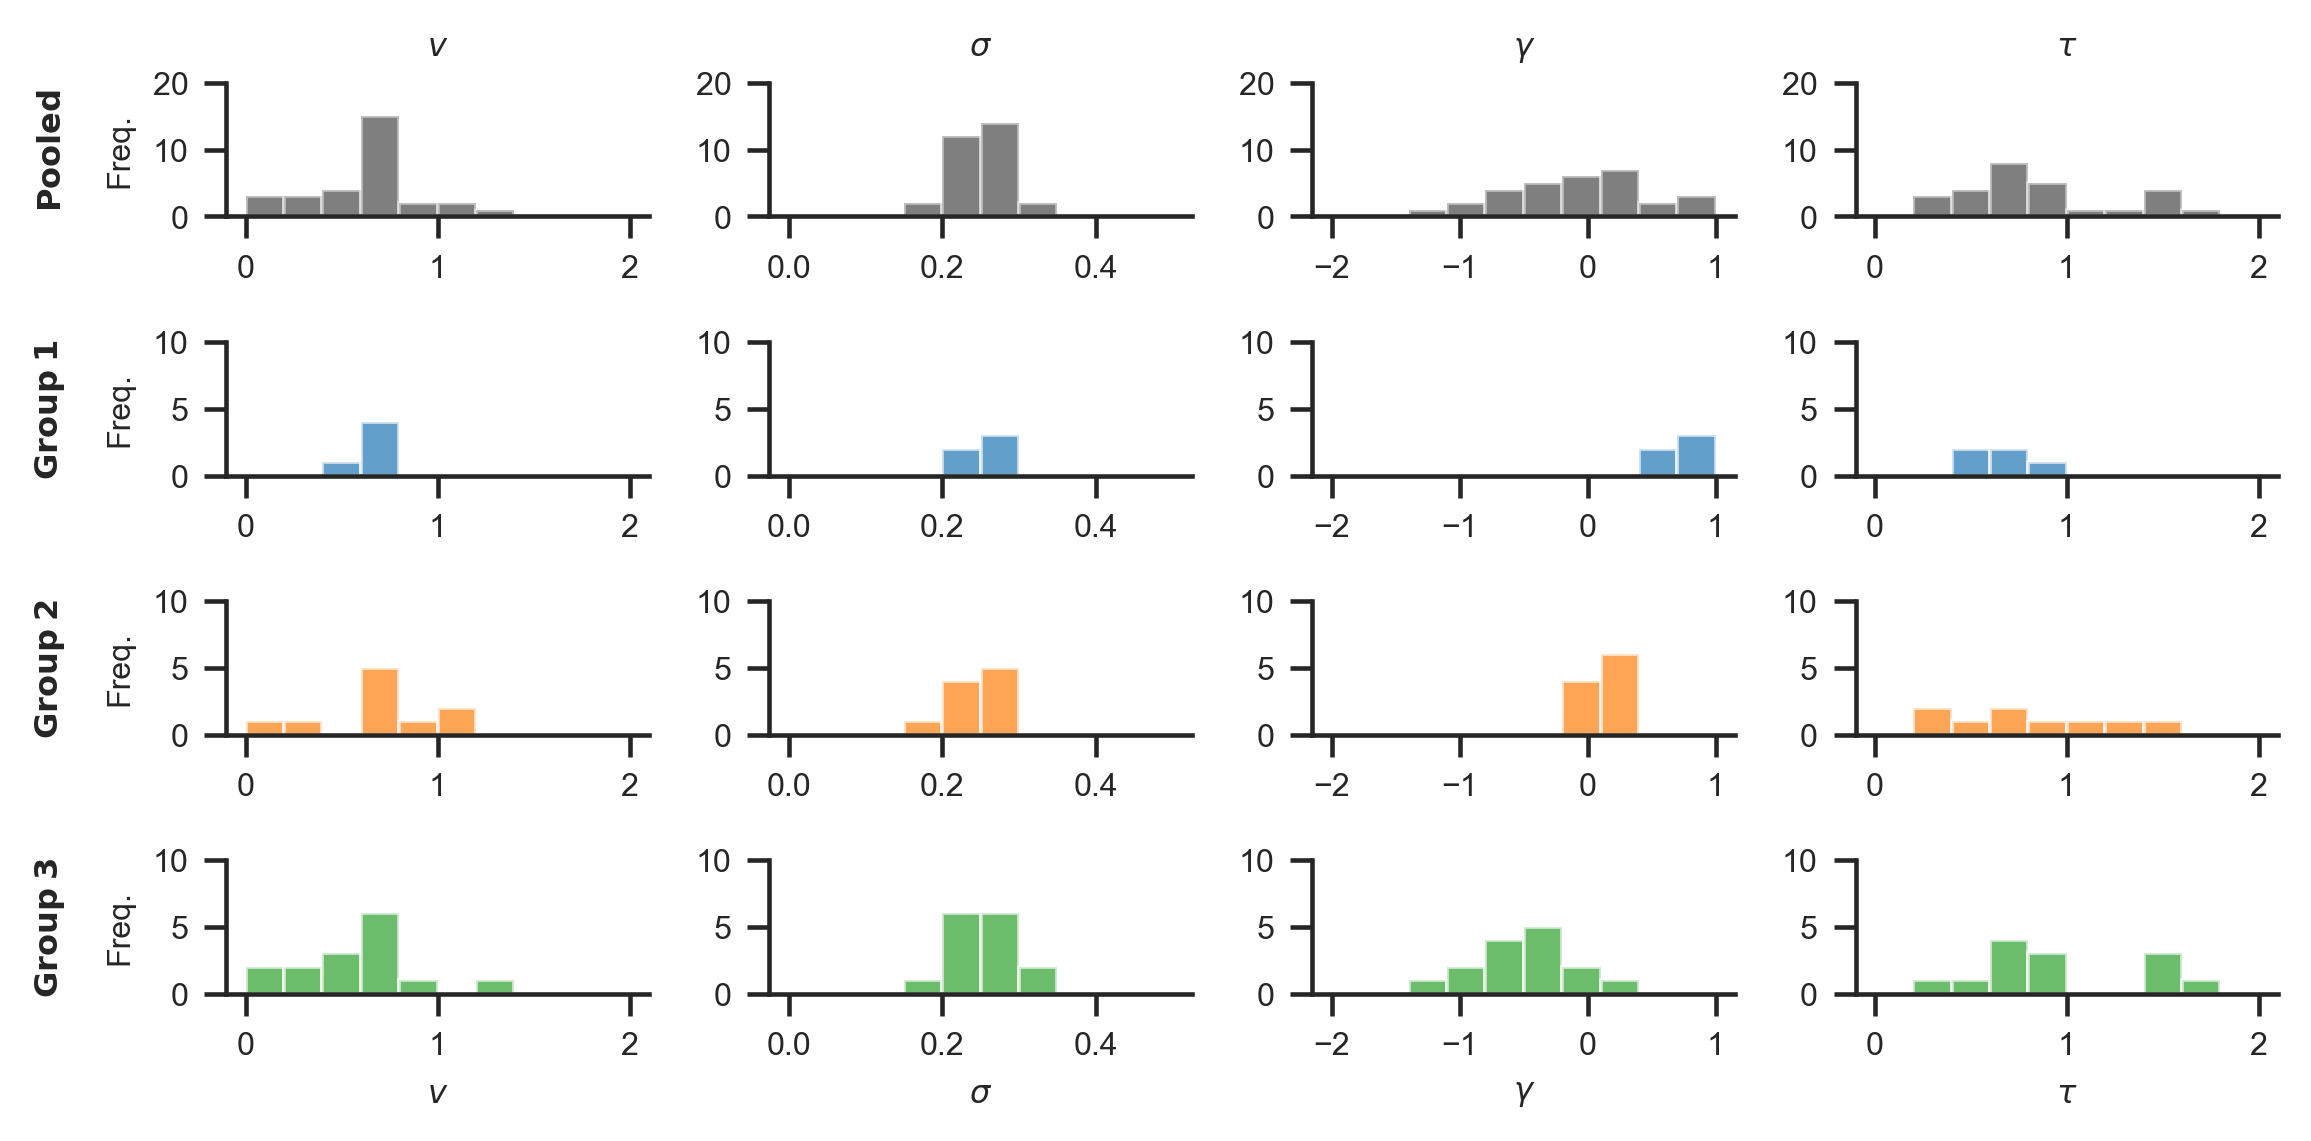

In [4]:
from string import ascii_uppercase

fontsize = 7
n_bins = 10

fig, axs = plt.subplots(4, 4, figsize=gb.plots._plots_internal.cm2inch(18, 9), sharex='col', dpi=330)

for p, (parameter, parameter_name, bins) in enumerate(
    zip([v, s, gamma, tau],
        [r'$v$', r'$\sigma$', r'$\gamma$', r'$\tau$'],
        [np.linspace(0, 2, n_bins + 1),
         np.linspace(0, 0.5, n_bins + 1),
         np.linspace(-2, 1, n_bins + 1),
         np.linspace(0, 2, n_bins + 1)])):
    
    # Pooled
    axs[0, p].hist(np.concatenate([parameter[group] for group in groups]),
                   bins=bins,
                   color='black',
                   alpha=0.5)
    axs[0, p].set_ylim(0, 20)
    axs[0, p].set_yticks([0, 10, 20])
    axs[0, p].set_title(parameter_name, fontsize=fontsize, fontweight='bold')
    if p == 0:
        axs[0, p].set_ylabel(r'$\bf{Pooled}$' + '\n\nFreq.', fontsize=fontsize)

    # Groups
    for g, group in enumerate(groups):
        axs[g + 1, p].hist(parameter[group],
                           bins=bins,
                           color='C{}'.format(g),
                           alpha=0.7)
        axs[g + 1, p].set_ylim(0, 1)
        axs[g + 1, p].set_yticks([0, 5, 10])
        if p == 0:
            axs[g + 1, p].set_ylabel(r'$\bf{Group}$ ' + r'$\bf{{{g}}}$'.format(g=(g + 1)) + '\n\nFreq.',
                                     fontsize=fontsize)

    axs[g + 1, p].set_xlabel(parameter_name, fontsize=fontsize)
    
for ax, letter in zip(axs.ravel(), ascii_uppercase):
    # Show ticklabels, despite sharey=True
    ax.xaxis.set_tick_params(labelbottom=True)
    ax.yaxis.set_tick_params(labelbottom=True)
    ax.tick_params(axis='both', which='major', labelsize=fontsize)

sns.despine()
    
fig.tight_layout(pad=1.02)

plt.savefig('examples/example_2/figures/generating_parameters.png', dpi=330)

## 2. Exploring behavioural differences

Behavioural differences between the three groups are plotted below, using the `plot_behaviour_aggregate` function from the `plots` module. Group-level summary tables can be created using the `aggregate_group_level_data` from the `analysis` module. Even though the groups only differ in the gaze bias parameter $\gamma$, they also exhibit differences in RT (Group 1 mean ± s.d. = 1.96 ± 0.33 s, Group 2 mean ± s.d. = 2.38 ± 1.4 s; Group 3 mean ± s.d. = 2.59 ± 1.26 ms; A) and choice accuracy (Group 1 mean ± s.d. = 0.88 ± 0.06, Group 2 mean ± s.d. = 0.71 ± 0.07, Group 3 mean ± s.d. = 0.50 ± 0.16; B). As is to be expected, we can also observe behavioural differences in gaze influence measure (Group 1 mean ± s.d. = 0.08 ± 0.07, Group 2 mean ± s.d. = 0.26 ± 0.11, Group 3 mean ± s.d. = 0.38 ± 0.11; C-D, where the choices of Group 3 are driven by gaze more than those of the other groups.

In [5]:
parameters = ['v', 'gamma', 's', 'tau']
comparisons=[('group1', 'group2'),
             ('group1', 'group3'),
             ('group2', 'group3')]

for p, parameter in zip([v, gamma, s, tau], ['v', 'gamma', 's', 'tau']):
    print(parameter)
    for comparison in comparisons:
        g1, g2 = comparison
        print('{} vs {}\t'.format(g1, g2), ttest_ind(p[g1], p[g2]))

v
group1 vs group2	 Ttest_indResult(statistic=-0.3063071158648262, pvalue=0.7642213460655614)
group1 vs group3	 Ttest_indResult(statistic=0.5357661157553092, pvalue=0.5986787412351837)
group2 vs group3	 Ttest_indResult(statistic=0.9437792037490204, pvalue=0.35509174773278895)
gamma
group1 vs group2	 Ttest_indResult(statistic=6.4021176850791575, pvalue=2.3355862858023058e-05)
group1 vs group3	 Ttest_indResult(statistic=6.8208382105890335, pvalue=2.193832426730825e-06)
group2 vs group3	 Ttest_indResult(statistic=4.837346716941595, pvalue=6.985175866537608e-05)
s
group1 vs group2	 Ttest_indResult(statistic=0.8636132045092535, pvalue=0.4034531813427481)
group1 vs group3	 Ttest_indResult(statistic=0.004104731012479496, pvalue=0.9967700581739689)
group2 vs group3	 Ttest_indResult(statistic=-0.8970137843731146, pvalue=0.37900526220793296)
tau
group1 vs group2	 Ttest_indResult(statistic=-0.8378245121922042, pvalue=0.417267319030197)
group1 vs group3	 Ttest_indResult(statistic=-1.61664947481003

In [6]:
data.groupby('group').apply(gb.analysis.aggregate_group_level_data, n_items=n_items)

mean       std       min       max        se  \
group                                                                     
group1 Mean RT         1.960980  0.326799  1.531284  2.503894  0.163400   
       P(choose best)  0.876000  0.062482  0.760000  0.920000  0.031241   
       Gaze Influence  0.077391  0.066525 -0.005919  0.142432  0.033263   
group2 Mean RT         2.381671  1.402121  1.238400  5.187776  0.467374   
       P(choose best)  0.706000  0.065146  0.600000  0.800000  0.021715   
       Gaze Influence  0.255080  0.112799  0.103472  0.440610  0.037600   
group3 Mean RT         2.588283  1.256759  1.240456  6.318852  0.335883   
       P(choose best)  0.498667  0.155857  0.280000  0.820000  0.041655   
       Gaze Influence  0.382977  0.112599  0.144232  0.652829  0.030093   

                            iqr  
group                            
group1 Mean RT         0.304160  
       P(choose best)  0.060000  
       Gaze Influence  0.133686  
group2 Mean RT         0.336601  
       P(choose best)  0.100000  
       Gaze Influence  0.174701  
group3 Mean RT         0.872888  
       P(choose best)  0.200000  
       Gaze Influence  0.122224

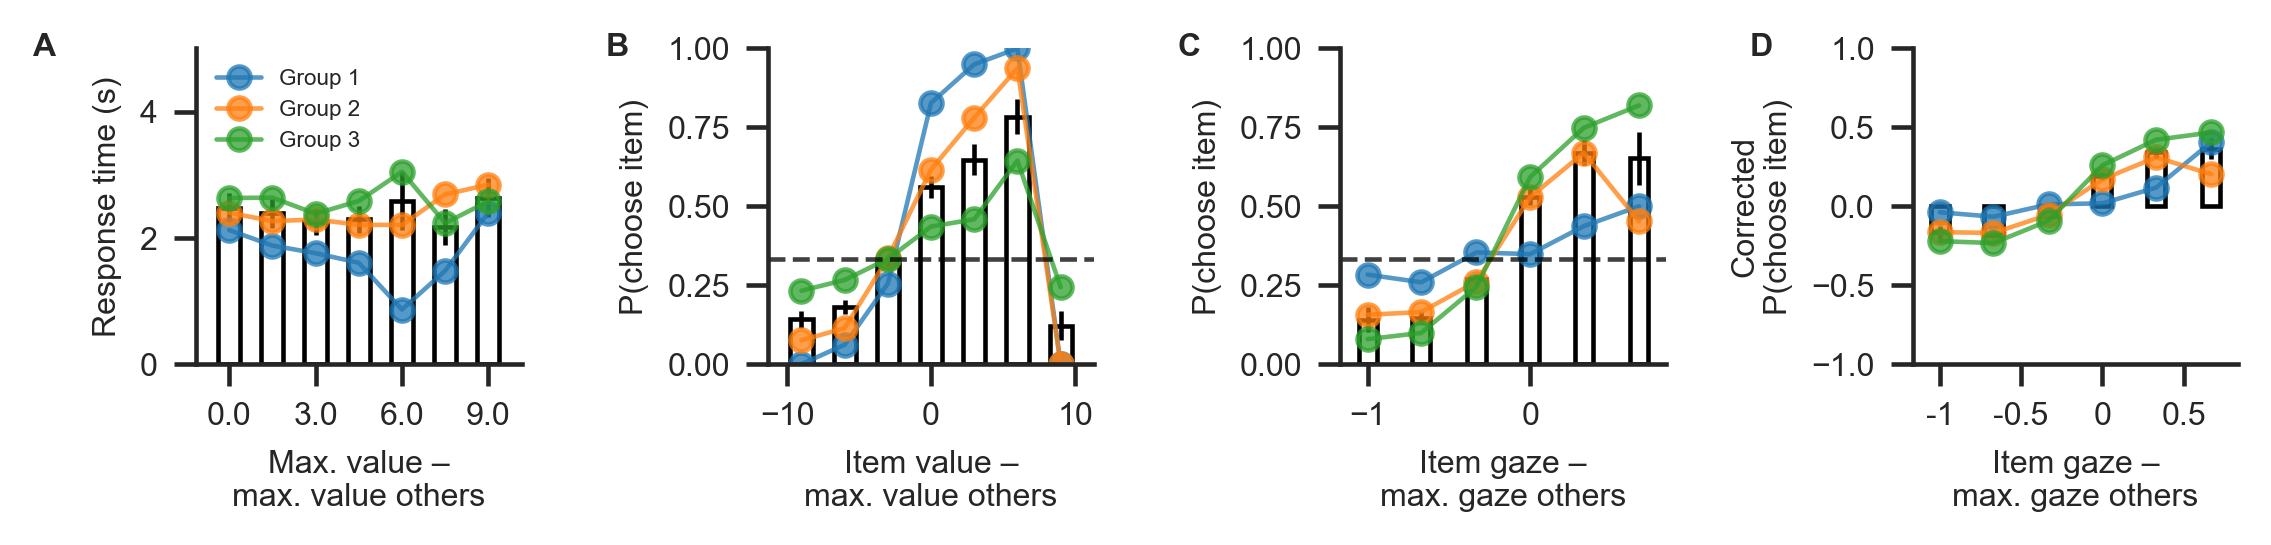

In [7]:
gb.plots.plot_behaviour_aggregate(bar_data=data,
                                  line_data=[data.loc[data['group'] == group] for group in groups],
                                  line_labels=['Group 1', 'Group 2', 'Group 3'],
                                  value_bins=7, gaze_bins=7,
                                  limits=dict(rt=(0, 5)));
sns.despine()
plt.savefig('examples/example_2/figures/aggregate_data.png', dp=330)

## 3. Building the hierarchical model

When specifying the hierarchical model, we allow all model parameters to differ between the three groups. This way, we will subsequently be able to address the question whether individuals from different groups differ on one or more model parameters (including the gaze bias parameter $\gamma$, which we are mainly interested in here).

As for the individual models, we first initialize the model object using the `GLAM` class and supply it with the behavioural data using the `data` argument. Here, we set the model kind `'hierarchical'` (in contrast to `'individual'`. Further, we specify that each model parameter can vary between groups (referring to a `'group'` variable in the data):

In [8]:
hglam = gb.GLAM(data=data)
hglam.make_model(kind='hierarchical',
                 depends_on=dict(v='group',
                                 gamma='group',
                                 s='group',
                                 tau='group'))

Generating hierarchical model for 30 subjects...


In this model, each parameter is set up hierarchically within each group, so that individual estimates are informed by other individuals in that group. If the researcher does not expect group differences on a parameter, this parameter can simply be omitted from the `depends_on` dictionary. The resulting model would then have a hierarchical setup of this parameter across groups, so that individual parameter estimates were informed by all other individuals (not only those in the same group).

## 4. Parameter estimation

After the model is built, the next step is to perform statistical inference over its parameters. As we have done with the individual models, we can use MCMC to approximate the parameters' posterior distributions (see the Methods Section of the manuscript for details). Due to the more complex structure and drastically increased number of parameters, the chains from the hierarchical model usually have higher levels autocorrelation. To still obtain a reasonable number of effective samples (Kurschke (2014), we increase the number of `tuning`- and `draw` steps:

In [9]:
np.random.seed(1142)
hglam.fit(method='MCMC',
          draws=20000,
          tune=20000,
          chains=4,
          random_seed=1142)

Fitting 1 model(s) using MCMC...
  Fitting model 1 of 1...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau_group3]
>Metropolis: [tau_group2]
>Metropolis: [tau_group1]
>Metropolis: [tau_group3_sd]
>Metropolis: [tau_group2_sd]
>Metropolis: [tau_group1_sd]
>Metropolis: [tau_group3_mu]
>Metropolis: [tau_group2_mu]
>Metropolis: [tau_group1_mu]
>Metropolis: [s_group3]
>Metropolis: [s_group2]
>Metropolis: [s_group1]
>Metropolis: [s_group3_sd]
>Metropolis: [s_group2_sd]
>Metropolis: [s_group1_sd]
>Metropolis: [s_group3_mu]
>Metropolis: [s_group2_mu]
>Metropolis: [s_group1_mu]
>Metropolis: [gamma_group3]
>Metropolis: [gamma_group2]
>Metropolis: [gamma_group1]
>Metropolis: [gamma_group3_sd]
>Metropolis: [gamma_group2_sd]
>Metropolis: [gamma_group1_sd]
>Metropolis: [gamma_group3_mu]
>Metropolis: [gamma_group2_mu]
>Metropolis: [gamma_group1_mu]
>Metropolis: [v_group3]
>Metropolis: [v_group2]
>Metropolis: [v_group1]
>Metropolis: [v_group3_sd]
>Metropolis: [v_group2_sd]
>Metropolis: [v_group1_sd]
>Metropolis: [v_group3_mu]
>Metropo

/!\ Automatically setting parameter precision...


In [10]:
# saving the hierarchical parameter estimates
hglam.estimates.to_csv('examples/example_2/results/estimates.csv', index=False)

Check for convergence, using the Rhat measure and number of effective samples:

In [11]:
variables = [v for v in hglam.trace[0].varnames
             if not v.endswith('__')
             and not v in ['b', 'p_error', 't0']]

pm.summary(hglam.trace[0], var_names=variables).head()

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
v_group1_mu,0.655545,0.091426,0.001239,0.471340,0.837252,6536.876639,1.000135
v_group2_mu,0.695481,0.120024,0.001420,0.456701,0.935323,9496.736263,1.000189
v_group3_mu,0.614757,0.076902,0.000935,0.468496,0.773918,7983.230317,1.000011
v_group1_sd,0.167254,0.105907,0.001861,0.041294,0.383618,3369.765623,1.000453
v_group2_sd,0.364104,0.104120,0.001371,0.198576,0.573141,6578.210532,1.000039


.. looks good.

Let's also take a look at the traces for visual inspection:

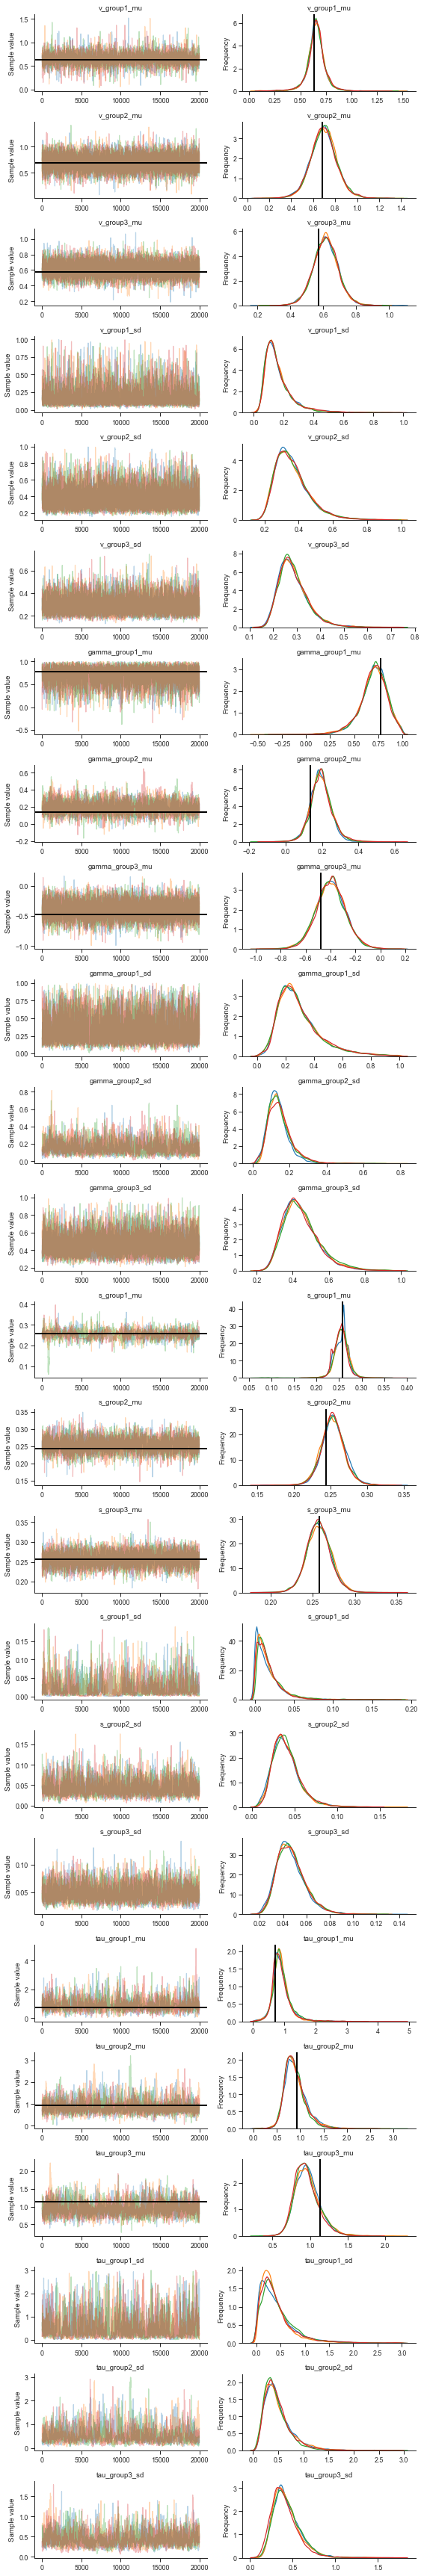

In [12]:
variables = [v for v in variables
             if v.endswith('_mu')
             or v.endswith('_sd')]

gb.plots.traceplot(hglam.trace[0],
                   varnames=variables,
                   # specify data generating reference values (vertical lines)
                   ref_val=dict(v_group1_mu=v['group1'].mean(),
                                v_group2_mu=v['group2'].mean(),
                                v_group3_mu=v['group3'].mean(),
                                gamma_group3_mu=gamma['group3'].mean(),
                                gamma_group1_mu=gamma['group1'].mean(),
                                gamma_group2_mu=gamma['group2'].mean(),
                                s_group3_mu=s['group3'].mean(),
                                s_group1_mu=s['group1'].mean(),
                                s_group2_mu=s['group2'].mean(),
                                tau_group3_mu=tau['group3'].mean(),
                                tau_group1_mu=tau['group1'].mean(),
                                tau_group2_mu=tau['group2'].mean()))

plt.savefig('examples/example_2/figures/traceplot.png', dpi=330)
sns.despine()

.. the traces also visually look good.

## 5. Evaluating parameter estimates, interpreting results

After sampling is finished, and the chains were checked for convergence (see above), we can turn back to the research question: *Do the groups differ with respect to their gaze biases?*

Questions about differences between group-level parameters can be addressed by inspecting their posterior distributions. For example, the probability that the mean $\gamma_{1,\mu}$ for Group 1 is larger than the mean $\gamma_{2,\mu}$ of Group 2 is given by the proportion of posterior samples in which this was the case.

GLAMbox includes a `compare_parameters` function that plots posterior distributions of group level parameters. Additionally, the user can specify a list of `comparisons` between groups or conditions. If comparisons are specified, the posterior distributions of their difference and corresponding relevant statistics are added to the figure:

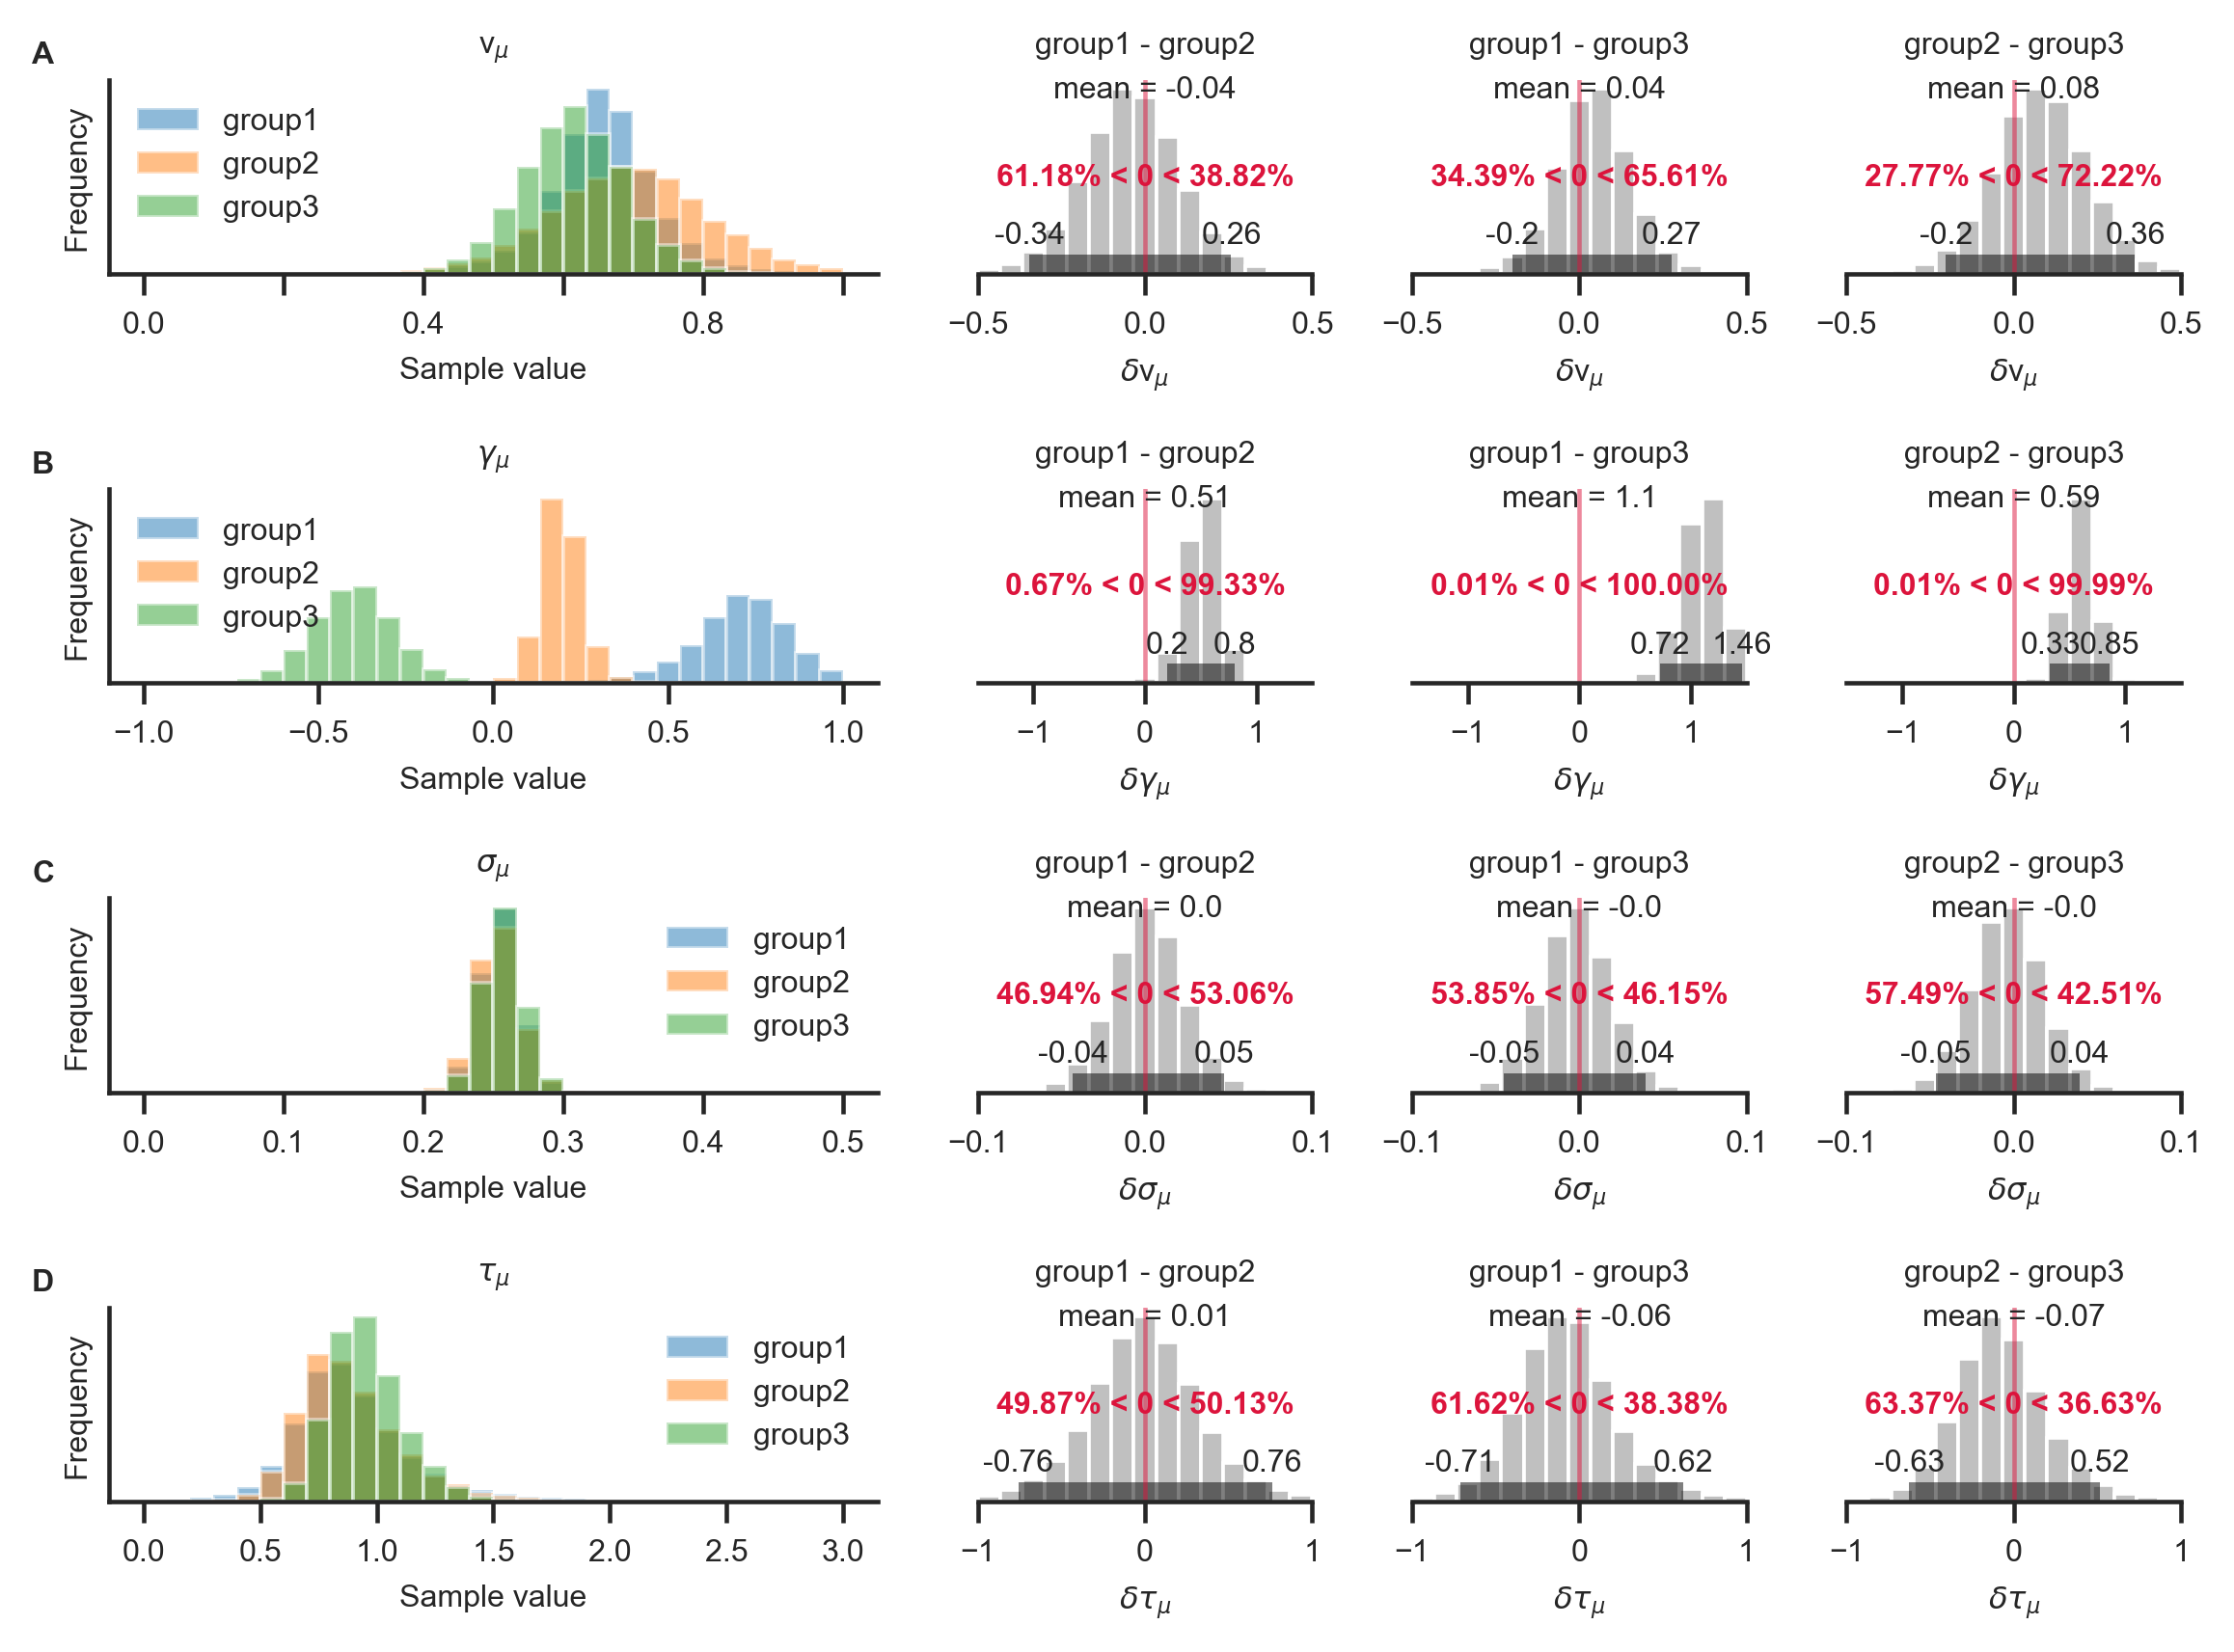

In [13]:
from glambox.plots import compare_parameters

parameters = ['v', 'gamma', 's', 'tau']
comparisons = [('group1', 'group2'),
               ('group1', 'group3'),
               ('group2', 'group3')]

compare_parameters(model=hglam,
                   parameters=parameters,
                   comparisons=comparisons);

plt.savefig('examples/example_2/figures/node_comparison.png', dpi=330)

With the resulting plot (see above), the researcher can infer that the groups did not differ with respect to their mean velocity parameters $v_{i,\mu}$ (A; top row, pairwise comparisons), mean accumulation noise $\sigma_{i,\mu}$ (C; third row), or scaling parameters $\tau_{i,\mu}$ (D; fourth row). The groups differ, however, in the strength of their mean gaze bias $\gamma_{i,\mu}$ (B; second row): All differences between the groups were statistically meaningful (as inferred by the fact that the corresponding 95\% HPD did not contain zero; B, second row, columns 2-4).

## 6. References

- Krajbich, I., & Rangel, A. (2011). Multialternative drift-diffusion model predicts the relationship between visual fixations and choice in value-based decisions. Proceedings of the National Academy of Sciences, 108(33), 13852-13857.

- Kruschke, J. (2014). Doing Bayesian data analysis: A tutorial with R, JAGS, and Stan. Academic Press.

- Lerche, V., Voss, A., & Nagler, M. (2017). How many trials are required for parameter estimation in diffusion modeling? A comparison of different optimization criteria. Behavior Research Methods, 49(2), 513-537.

- Ratcliff, R., & Childers, R. (2015). Individual differences and fitting methods for the two-choice diffusion model of decision making. Decision, 2(4), 237.

- Vaidya, A. R., & Fellows, L. K. (2015). Testing necessary regional frontal contributions to value assessment and fixation-based updating. Nature communications, 6, 10120.

- Voss, A., Nagler, M., & Lerche, V. (2013). Diffusion models in experimental psychology. Experimental psychology.

- Wiecki, T. V., Sofer, I., & Frank, M. J. (2013). HDDM: Hierarchical Bayesian estimation of the drift-diffusion model in Python. Frontiers in neuroinformatics, 7, 14.